In [1]:
import torch
import torchvision
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from torchviz import make_dot
from tqdm import tqdm

from ipvae import iPVAE
# from pcmodel import iPVAE

from dataset import PreloadedDataset



In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
device

device(type='cuda')

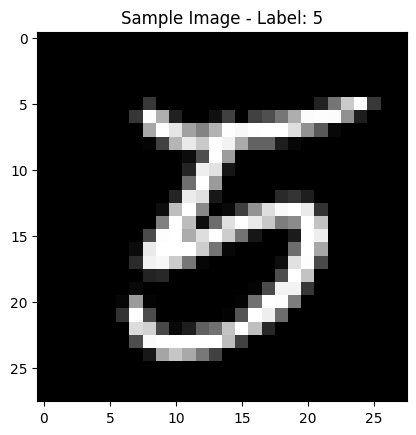

In [3]:
# Load the MNIST dataset
mnist_train = datasets.MNIST(root='../../Datasets/', train=True, download=False, transform=torchvision.transforms.ToTensor())
mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [50000, 10000])
mnist_test = datasets.MNIST(root='../../Datasets/', train=False, download=False, transform=torchvision.transforms.ToTensor())
train = PreloadedDataset.from_dataset(mnist_train, None, device, use_tqdm=True)
val = PreloadedDataset.from_dataset(mnist_val, None, device, use_tqdm=True)
test = PreloadedDataset.from_dataset(mnist_test, None, device, use_tqdm=True)

# Display a sample image from the dataset
sample_image, sample_label = mnist_train[0]
plt.imshow(sample_image.squeeze().cpu(), cmap='gray')
plt.title(f'Sample Image - Label: {sample_label}')
plt.show()


Best loss: 509.7017074896365


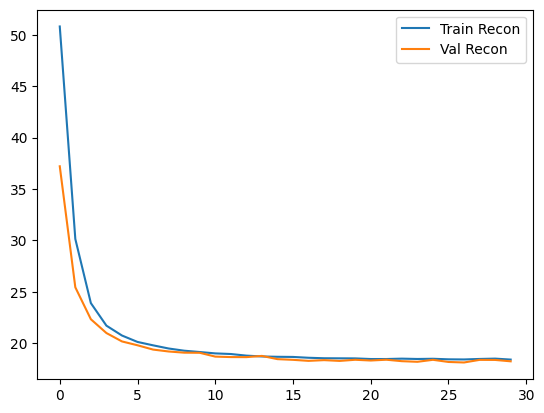

In [8]:
num_features = 128
alpha = 1.0
mode='mlp'
T = 16
beta = 5.0

num_epochs = 30
learning_rate = 0.001
batch_size = 512

model = iPVAE(num_features=num_features, alpha=alpha, mode=mode).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=True)

train_losses_recon = []
train_losses_kl = []
train_losses = []
val_losses_recon = []
val_losses_kl = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss_recon = 0
    train_loss_kl = 0
    train_loss = 0

    num_batches = 0
    loop = tqdm(train_loader, leave=False)
    if epoch > 0:
        loop.set_description(f'Epoch [{epoch+1}/{num_epochs}] - Loss: {train_losses[-1]:.3e} - KL: {train_losses_kl[-1]:.3e} - Train MSE: {train_losses_recon[-1]:.3e} - Val MSE: {val_losses_recon[-1]:.3e}')
    for images, _ in loop:
        images = images.unsqueeze(1).to(device)
        
        optimizer.zero_grad()
        _, losses_recon, losses_kl = model(images, T=T, losses=True)
        loss = sum(losses_recon) + beta*sum(losses_kl)
        loss.backward()
        optimizer.step()
        
        train_loss_recon += losses_recon[-1].item()
        train_loss_kl += losses_kl[-1].item()
        train_loss += loss.item()
        num_batches += 1

    train_loss_recon = train_loss_recon / num_batches
    train_loss_kl = train_loss_kl / num_batches
    train_loss = train_loss / num_batches

    model.eval()
    val_loss_recon = 0
    val_loss_kl = 0
    val_loss = 0
    num_batches = 0

    _, losses_recon, losses_kl = model(val.images, T=T, losses=True)
    loss = sum(losses_recon) + beta*sum(losses_kl)
    val_loss_recon += losses_recon[-1].item()
    val_loss_kl += losses_kl[-1].item()
    val_loss += loss.item()
    num_batches += 1
    
    val_loss_recon = val_loss_recon / num_batches
    val_loss_kl = val_loss_kl / num_batches
    val_loss = val_loss / num_batches

    train_losses_kl.append(train_loss_kl)
    train_losses_recon.append(train_loss_recon)
    train_losses.append(train_loss)
    val_losses_kl.append(val_loss_kl)
    val_losses_recon.append(val_loss_recon)
    val_losses.append(val_loss)

print(f'Best loss: {min(train_losses)}')
plt.plot(train_losses_recon, label='Train Recon')
plt.plot(val_losses_recon, label='Val Recon')
plt.legend()
plt.show()


In [9]:
model_name = f'{mode}-{num_features}D-{alpha}a-{T}T-{beta}b'
torch.save(model.state_dict(), f'models/{model_name}.pth')

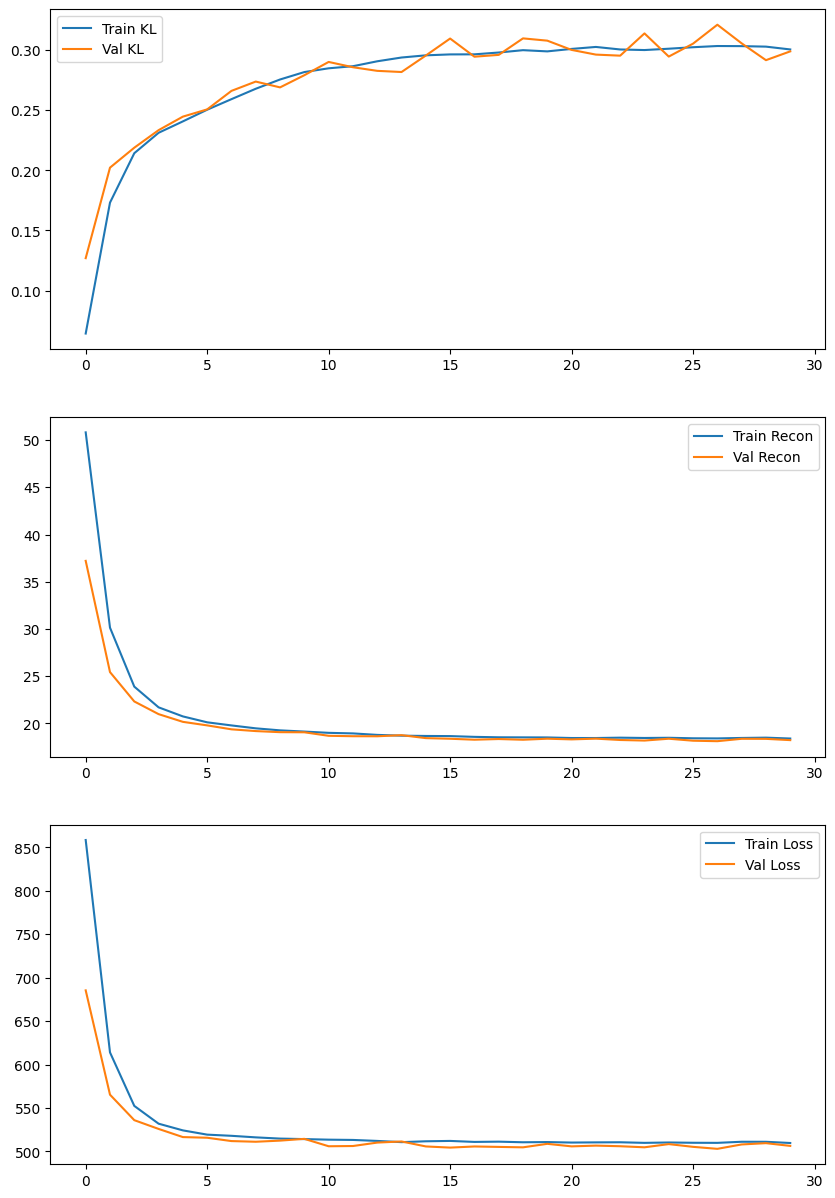

In [10]:
fig, axs = plt.subplots(3, 1, figsize=(10, 15))
axs[0].plot(train_losses_kl, label='Train KL')
axs[0].plot(val_losses_kl, label='Val KL')
axs[1].plot(train_losses_recon, label='Train Recon')
axs[1].plot(val_losses_recon, label='Val Recon')
axs[2].plot(train_losses, label='Train Loss')
axs[2].plot(val_losses, label='Val Loss')
for ax in axs.flatten():
    ax.legend()
plt.show()

torch.Size([10, 784])


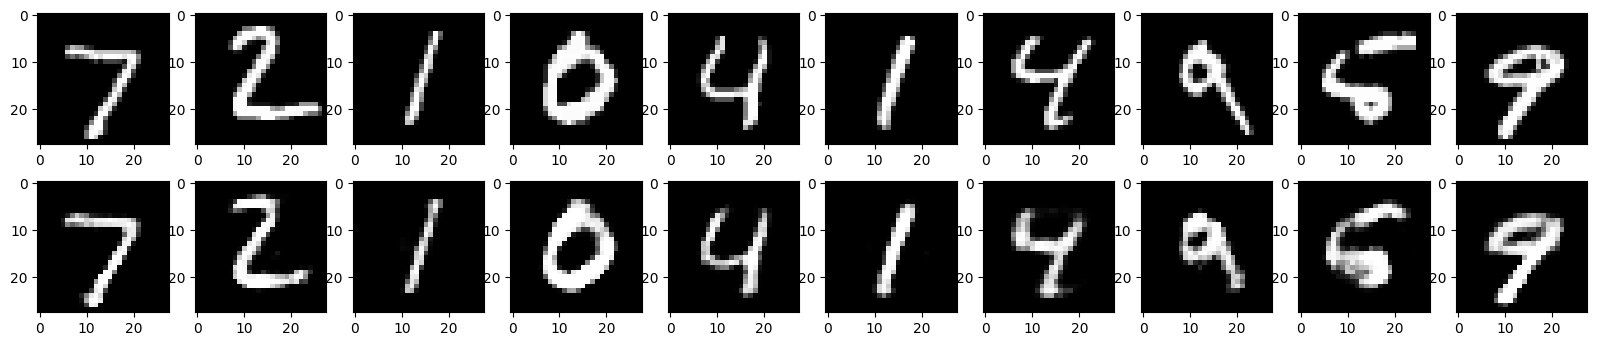

In [11]:
x = test.images[:10]
z = model(x, T=1000)
preds = model.decoder(z)
print(preds.shape)
if preds.dim() == 2:
    preds = preds.reshape(preds.shape[0], 1, 28, 28)
fig, axs = plt.subplots(2, 10, figsize=(20, 4))
for i in range(10):
    axs[0, i].imshow(x[i].squeeze().cpu(), cmap='gray')
    axs[1, i].imshow(preds[i].squeeze().detach().cpu(), cmap='gray')
plt.show()

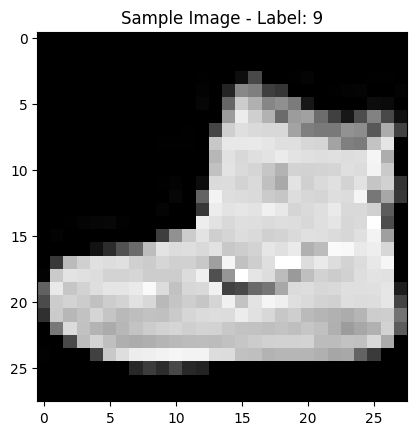

In [17]:
# Load the FashionMNIST dataset
fashion_train = datasets.FashionMNIST(root='../../Datasets/', train=True, download=True, transform=torchvision.transforms.ToTensor())
fashion_test = datasets.FashionMNIST(root='../../Datasets/', train=False, download=True, transform=torchvision.transforms.ToTensor())
ftrain = PreloadedDataset.from_dataset(fashion_train, None, device, use_tqdm=True)
ftest = PreloadedDataset.from_dataset(fashion_test, None, device, use_tqdm=True)

# Display a sample image from the dataset
sample_image, sample_label = fashion_train[0]
plt.imshow(sample_image.squeeze().cpu(), cmap='gray')
plt.title(f'Sample Image - Label: {sample_label}')
plt.show()


torch.Size([10, 784])


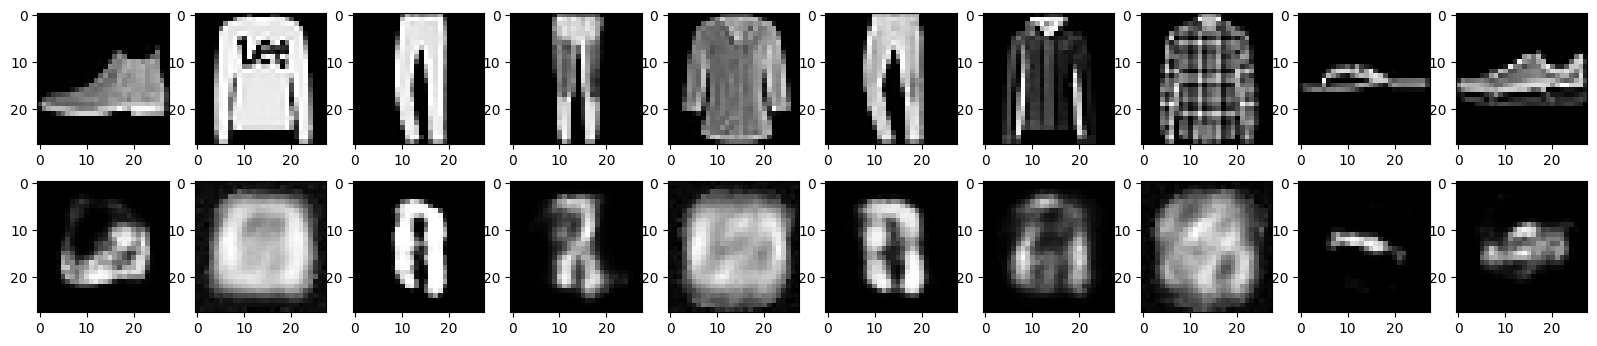

In [18]:
x = ftest.images[:10]
z = model(x, steps=1000)
preds = model.decoder(z)
print(preds.shape)
if preds.dim() == 2:
    preds = preds.reshape(preds.shape[0], 1, 28, 28)
fig, axs = plt.subplots(2, 10, figsize=(20, 4))
for i in range(10):
    axs[0, i].imshow(x[i].squeeze().cpu(), cmap='gray')
    axs[1, i].imshow(preds[i].squeeze().detach().cpu(), cmap='gray')
plt.show()

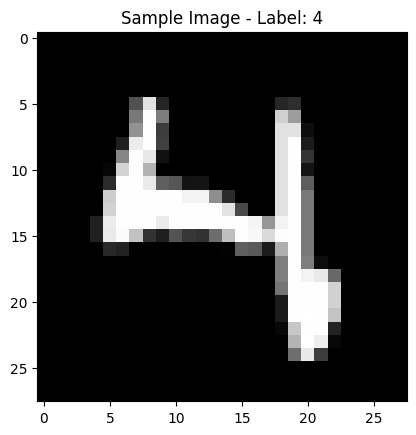

In [12]:
import torch.nn as nn
# Train Classifier

# Load the MNIST dataset
subset_size = 100
mnist_train = datasets.MNIST(root='../../Datasets/', train=True, download=False, transform=torchvision.transforms.ToTensor())
mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [subset_size, 60000-subset_size])
mnist_test = datasets.MNIST(root='../../Datasets/', train=False, download=False, transform=torchvision.transforms.ToTensor())
train = PreloadedDataset.from_dataset(mnist_train, None, device, use_tqdm=True)
val = PreloadedDataset.from_dataset(mnist_val, None, device, use_tqdm=True)
test = PreloadedDataset.from_dataset(mnist_test, None, device, use_tqdm=True)

# Display a sample image from the dataset
sample_image, sample_label = mnist_train[0]
plt.imshow(sample_image.squeeze().cpu(), cmap='gray')
plt.title(f'Sample Image - Label: {sample_label}')
plt.show()

# Create classifier and specify training parameters
classifier = nn.Sequential(
    nn.BatchNorm1d(model.num_features, affine=False) if cfg['bn_output'] else nn.Identity(),
    nn.Linear(model.num_features, 10, bias=False),
).to(device)
batch_size = max(n_per_class, 10)
num_epochs = 100 if cfg['dataset'] == 'mnist' else 200
lr = 0.1

if cfg['dataset'] == 'mnist':
    train = MNIST(cfg['root'], split='train', n=n_per_class, device=cfg['device'], use_tqdm=cfg['local'])
    val = MNIST(cfg['root'], split='val', device=cfg['device'], use_tqdm=cfg['local'])

elif cfg['dataset'] == 'modelnet10':
    train = ModelNet10Simple(cfg['root'], split='train', n=n_per_class, device=cfg['device'], use_tqdm=cfg['local'], rank=cfg['ddp_rank'], world_size=cfg['ddp_world_size'], seed=cfg['seed'])
    val = ModelNet10Simple(cfg['root'], split='val', n=10, device=cfg['device'], use_tqdm=cfg['local'], rank=cfg['ddp_rank'], world_size=cfg['ddp_world_size'], seed=cfg['seed'])

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val, batch_size=1000, shuffle=False)

param_dict = {pn: p for pn, p in classifier.named_parameters()}
param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}
decay_params = [p for n, p in param_dict.items() if 'bn' not in n and 'bias' not in n]
nondecay_params = [p for n, p in param_dict.items() if 'bn' in n or 'bias' in n]